In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

In [4]:
# import reference file
enbasedf = pd.read_excel("./letterlang test/ref/letterorderen_full.xlsx")
thbasedf = pd.read_excel("./letterlang test/ref/letterorderth_full.xlsx")

In [5]:
# clean data, cut and add the data column into base df
def cut_and_clean(basedf, prepdf):
    cutdf = prepdf.iloc[1:97][["lang","langpair","sequence","pairid","key_resp.keys","key_resp.rt"]].reset_index()
    cutdf = cutdf.rename({"key_resp.keys":"key","key_resp.rt":"key_RT"}, axis="columns")
    newdf = basedf
    newdf = newdf.drop(['secondletter', 'seconddir'], axis = 1)
    newdf["key"] = cutdf["key"]
    newdf["key_RT"] = cutdf["key_RT"]
    return newdf


In [6]:
# assign score for speicific condition
def assign_score(df):
    # Create a boolean mask for 'sequence' and 'key' conditions
    mask_seq_1_z = (df['sequence'] == 1) & (df['key'] == 'z')
    mask_seq_2_x = (df['sequence'] == 2) & (df['key'] == 'x')

    # Assign scores based on conditions
    df['score'] = 0  # Default score
    df.loc[mask_seq_1_z, 'score'] = 1
    df.loc[mask_seq_2_x, 'score'] = 1

In [7]:
# assign the letter shown language as a langshow column
def interpret_lang(df):
    # Define conditions based on 'lang' and 'sequence'
    condition_1 = (df['sequence'] == 1) & (df['lang'] == 1)
    condition_2 = (df['sequence'] == 1) & (df['lang'] == 2)
    condition_3 = (df['sequence'] == 2) & (df['lang'] == 1)
    condition_4 = (df['sequence'] == 2) & (df['lang'] == 2)

    # Use numpy.select to vectorize the mapping logic
    langshow = np.select(
        [condition_1 & (df['langpair'] == 1), condition_1 & (df['langpair'] == 2), condition_1 & (df['langpair'] == 3),
         condition_2 & (df['langpair'] == 1), condition_2 & (df['langpair'] == 2), condition_2 & (df['langpair'] == 3),
         condition_3, condition_4],
        ['English', 'Khmer', 'Greek', 
         'Thai', 'Khmer', 'Greek', 
         'Thai', 'English'],
        default='Unknown'
    )

    # Assign the result to the 'langshow' column
    df['langshow'] = langshow




In [8]:
import pandas as pd
import glob
import os

path = './data/letterlang test - data/'
all_files = glob.glob(os.path.join(path , "*.csv"))

li, lien, lith = [], [], []

for filename in all_files:
    user_lang_list = filename.split('_M')[0].split('- data\\')[1].split('_')
    username = user_lang_list[0]
    

    df = pd.read_csv(filename, index_col=None, header=0)
    lang = df['lang'].mean()

    if lang == 1:
        df = cut_and_clean(thbasedf, df)
    elif lang == 2:
        df = cut_and_clean(enbasedf, df)
    else:
        print("RENAME YOUR FREAKY ASS FILE NAME")
        break
    
    assign_score(df)
    interpret_lang(df)
    df['username'] = username

    li.append(df)
    if lang == 1:
        lith.append(df)
    elif lang == 2:
        lien.append(df)

if len(li) == len(lien) + len(lith) and len(lien) == len(lith):
    n_subj = len(lith)
    print("validity = OK!")
else:
    print("caution,",len(li),"lists discrepancy compared to", len(lith),"and", len(lien) )

validity = OK!


In [9]:
lith[0]

,lang,langpair,sequence,pairid,firstletter,firstdir,key,key_RT,score,langshow,username
0,1,1,2,1,y,letter/letten092.png,x,0.366091,1,Thai,DM
1,1,3,2,8,ω,letter/lettgr153.png,x,1.241157,1,Thai,DM
2,1,1,2,1,y,letter/letten092.png,x,0.339115,1,Thai,DM
3,1,2,2,4,គ,letter/lettkh034.png,z,0.021399,0,Thai,DM
4,1,2,2,4,គ,letter/lettkh034.png,z,2.246449,0,Thai,DM
...,...,...,...,...,...,...,...,...,...,...,...
91,1,1,2,4,g,letter/letten091.png,x,0.348091,1,Thai,DM
92,1,2,2,3,ឭ,letter/lettkh031.png,x,0.228601,1,Thai,DM
93,1,3,1,8,ภ,letter/lettth013.png,z,0.261118,1,Greek,DM
94,1,1,1,2,ฉ,letter/lettth061.png,z,0.272856,1,English,DM


In [10]:
megadf = pd.concat(li, ignore_index = True)
megaendf = pd.concat(lien, ignore_index=True)
megathdf = pd.concat(lith, ignore_index=True)


In [11]:
redgradient = ["#ffa5bb","#ff9eb6", "#ff7d9d", "#ff6087","#ff0040" ] # thai language, use the last index value as the main color
bluegradient = ["#c0d7ff", "#92bcff", "#5e9eff","#3686ff","#0067ff" ] # english language, use the last index value as the main color
gaygradient = ["#949494", '#727272', '#4b4b4b', '#484848', '#373737'] # overall gradient
colincorrect = '#ff6962'
colcorrect  = '#77dd76'
patient = '#fc6600'
normcolor = '#2b7cd3'

In [12]:
# for our patient, call the file ./data/patient ...
patientpath = "./data/patient letterlang test/"
all_patientfiles = glob.glob(os.path.join(patientpath , "*.csv"))

li_patient = []
for filename in all_patientfiles:
    user_lang_list = filename.split('_M')[0].split('test\\')[1].split('_')
    print(user_lang_list)
    username = user_lang_list[0]
    lang = user_lang_list[1]

    df = pd.read_csv(filename, index_col=None, header=0)
    
    if lang == 'th':
        df = cut_and_clean(thbasedf, df)
    elif lang == 'en':
        df = cut_and_clean(enbasedf, df)
    else:
        print("RENAME YOUR FREAKY ASS FILE NAME")
        break
    
    assign_score(df)
    interpret_lang(df)
    df['username'] = username

    li_patient.append(df)

# welcome back
letterorden = li_patient[0]
letterorden = letterorden.drop(51)
letterordth = li_patient[1]
letterordall = pd.concat([letterorden, letterordth], ignore_index=True)


['YP', 'en']
['YP', 'th']


In [13]:
def legend_unique():
    handles, labels = plt.gca().get_legend_handles_labels()
    unique_labels = dict(zip(labels, handles))  # Removes duplicates
    plt.legend(unique_labels.values(), unique_labels.keys())

In [14]:
plotnormmean = {
    "color":normcolor,
    "marker" : 'D',
    "capsize" : 5
}

# Plot accuracy of the letter by language task

username         DM    GSR          KH          KN     KR       MW     NU  \
lang                                                                        
1         95.833333  100.0  100.000000   98.958333  100.0  100.000  100.0   
2         98.958333  100.0   97.916667  100.000000  100.0   96.875  100.0   

username        OAT         PH          PM          PT         SC         SS  
lang                                                                          
1         98.958333  97.916667   97.916667   98.958333  97.916667  95.833333  
2         87.500000  97.916667  100.000000  100.000000  93.750000  96.875000  


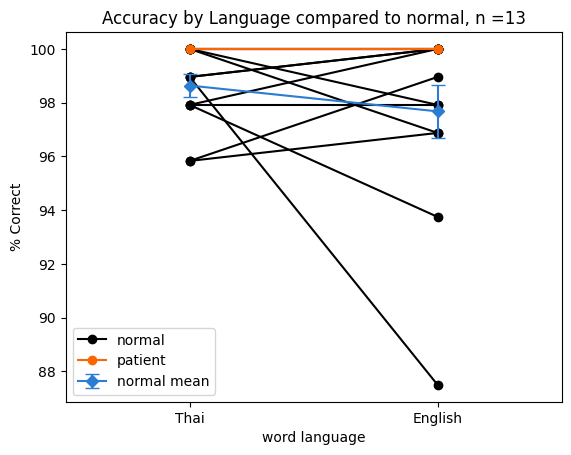

In [15]:
accumean = megadf.groupby(['lang', 'username'])['score'].mean().mul(100).unstack()

print(accumean)
for i, (ind, series) in enumerate(accumean.items()):
    plt.plot(series.index, series.values, color = 'black', marker = 'o', label = 'normal')


# calculate list of mean first for each language
thmean = megathdf.groupby(['username'])['score'].mean().mul(100)
enmean = megaendf.groupby(['username'])['score'].mean().mul(100)
plt.errorbar([1,2], [megathdf['score'].mean() *100, megaendf['score'].mean() *100], yerr = [thmean.sem(), enmean.sem()] , **plotnormmean, label = 'normal mean')

#plot patient
plt.plot([1,2], [letterordth['score'].mean() * 100, letterorden['score'].mean() * 100],  color = patient,marker = 'o', label = "patient")

plt.ylabel("% Correct")
plt.xlabel("word language")
plt.xticks([1,2], ["Thai", "English"])
plt.title(f"Accuracy by Language compared to normal, n ={n_subj}")

# save_plot("percentage correct by language")
plt.margins(x=0.5)
legend_unique()
plt.savefig("./figure/norm/I norm accu by language order.png")


# Plot accuracy by language

langshow
Thai       100.0
English    100.0
Khmer      100.0
Greek      100.0
Name: score, dtype: float64


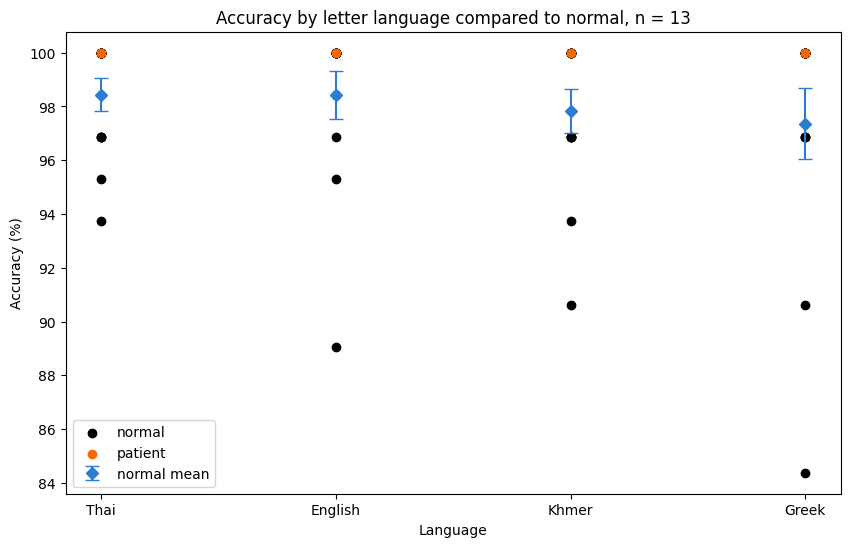

In [16]:
# scatterplot for all patient
accumean = megadf.groupby(['langshow', 'username'])['score'].mean().mul(100).unstack()
accumean = accumean.reindex(['Thai', 'English', 'Khmer','Greek'], level='langshow' )
fig, ax = plt.subplots(figsize=(10, 6))
for i, (ind, val) in enumerate(accumean.items()):
    plt.scatter(val.index, val.values, color = 'black', label = 'normal')

# mean of each letter language
mean = accumean.T.mean()
sem = accumean.T.sem()

plt.errorbar(mean.index, mean.values, yerr = sem.values, **plotnormmean, label = 'normal mean', linestyle = '')
# patient
ptmean = letterordall.groupby('langshow')['score'].mean().mul(100)
ptmean = ptmean.reindex(['Thai', 'English', 'Khmer','Greek'], level='langshow' )
print(ptmean)
plt.scatter(ptmean.index, ptmean.values, color = patient, label = 'patient')


plt.title(f"Accuracy by letter language compared to normal, n = {n_subj}")
plt.xlabel("Language")
plt.ylabel("Accuracy (%)")

legend_unique()
plt.savefig("./figure/norm/I norm accu by letterlang.png")

In [17]:
# # Aggregate data using pandas
# from matplotlib.patches import Patch
# from matplotlib.lines import Line2D

# # Plot setup
# fig, ax = plt.subplots(figsize=(10, 6))

# # normal 
# accumean = megadf.groupby(['langshow', 'lang', 'username'])['score'].mean().mul(100).unstack()
# accumean = accumean.reindex(['Thai', 'English', 'Khmer','Greek'], level = 'langshow')

# langshow_order = {"Thai": 1, "English": 2, "Khmer": 3, "Greek": 4}

# for user, v in accumean.items():
#     subdf = v.unstack()

#     for lang, list in subdf.items():
#         offset = 0.2*(lang-1.5)
#         xpos = [langshow_order.get(ll, 5) + offset for ll in list.index]

#         if lang == 1:
#             plt.scatter(xpos, list.values, color = bluegradient[2], label = "Normal, thai")
#         elif lang == 2:
#             plt.scatter(xpos, list.values, color = redgradient[2], label = "Normal, english")

# # normal mean
# mean = accumean.T.mean().unstack()
# sem = accumean.T.sem().unstack()

# for lang, list in mean.items():
#     offset = 0.2*(lang-1.5)
#     xpos = [langshow_order.get(ll, 5) + offset for ll in list.index]

#     if lang == 1:
#         plt.errorbar(xpos, list.values, yerr = sem[lang].values, marker = 'o', capsize= 5,  color =  'black', linestyle = '', label = "Normal mean, Thai")
#     elif lang == 2:
#         plt.errorbar(xpos, list.values, yerr = sem[lang].values, marker = 'x', capsize= 5,  color =  'black', linestyle = '', label = "Normal mean, English")

# plt.title(f"Accuracy of normal population by letter language and language order, n = {n_subj}")
# plt.xlabel("Language")
# plt.ylabel("Accuracy (%)")
# del list

# plt.xticks(list(langshow_order.values()), list(langshow_order.keys()))


# # patient
# ptmean = letterordall.groupby(['langshow', 'lang'])['score'].mean().mul(100).unstack()
# ptsem = letterordall.groupby(['langshow', 'lang'])['score'].sem().mul(100).unstack()
# print(ptmean)
# for lang, list in ptmean.items():
#     offset = 0.2*(lang-1.5)
#     xpos = [langshow_order.get(ll, 5) + offset for ll in list.index]

#     if lang == 1:
#         plt.errorbar(xpos, list.values, yerr = ptsem[lang].values, marker = 'o', capsize= 5,  color =  patient, linestyle = '', label = "Patient mean, Thai")
#     elif lang == 2:
#         plt.errorbar(xpos, list.values, yerr = ptsem[lang].values, marker = 'x', capsize= 5,  color =  patient, linestyle = '', label = "Patient mean, English")

# legend_unique()

# # plt.savefig("./figure/norm/I accu by letterlang and lang order.png")

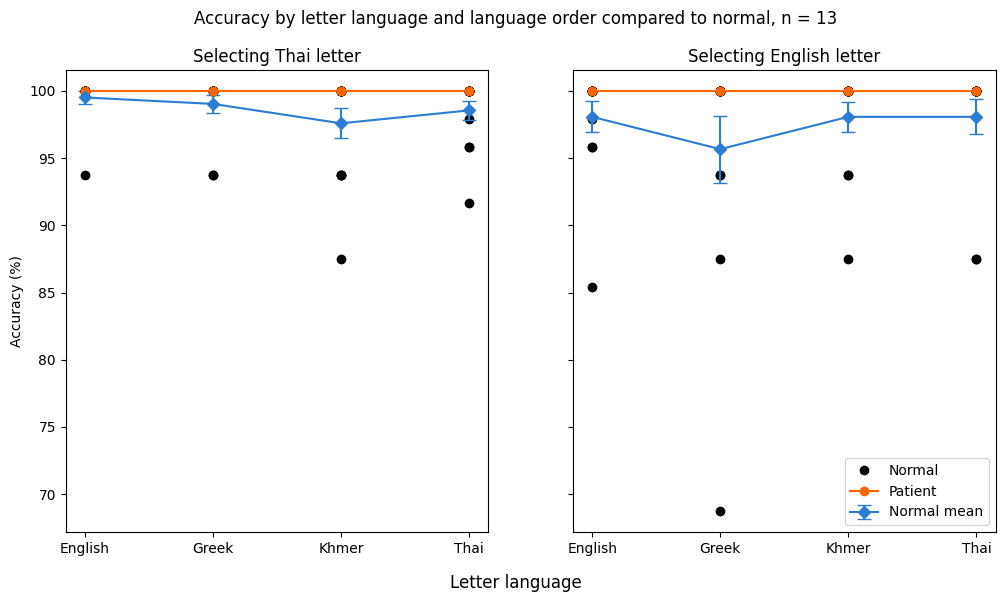

In [18]:
fig, axs = plt.subplots(1, 2, figsize = (12,6), sharey=True)
lister = [[megathdf, letterordth] , [megaendf, letterorden]]
for i in [0,1]:

    d = lister[i][0].groupby(['langshow', 'username'])['score'].mean().mul(100).unstack()
    for s, v in d.items():
        axs[i].plot(v.index, v.values, color = 'black', marker = 'o', linestyle = '', label = 'Normal')

    mean, sem = d.T.mean(), d.T.sem()
    axs[i].errorbar(mean.index, mean.values, yerr = sem.values, marker = 'D', color = normcolor, capsize = 5, label = 'Normal mean')
    p = lister[i][1].groupby(['langshow'])['score'].mean()*100
    s = lister[i][1].groupby(['langshow'])['score'].sem()*100
    axs[i].plot(p.index, p.values, color = patient, label = "Patient", marker = 'o')

fig.suptitle(f"Accuracy by letter language and language order compared to normal, n = {n_subj}")
fig.supxlabel("Letter language")
axs[0].set_ylabel("Accuracy (%)")
axs[0].set_title("Selecting Thai letter")
axs[1].set_title("Selecting English letter")

legend_unique()
plt.savefig("./figure/norm/I norm accu by letterlang and language order.png")



# reaction time by letter language
filter data first

In [19]:
# filter only the correct response
megadf_filter = megadf[megadf['score'] == 1].dropna()
megathdf_filter = megathdf[megathdf['score'] == 1].dropna()
megaendf_filter = megaendf[megaendf['score'] == 1].dropna()

letterorden_filter = letterorden[letterorden['score'] == 1].dropna()
letterordth_filter = letterordth[letterordth['score'] == 1].dropna()
letterordall_filter = letterordall[letterordall['score'] == 1].dropna()


## Normality and variance test
to use two sample t-test, the data should be
- normally distributed -->  Shapiro–Wilk test 
- equal variance --> Levene's test

In [20]:
# p < 0.05 --> not normally distributed
from scipy import stats

print("shapiro test in norm:", stats.shapiro(megadf_filter['key_RT']))
print("shapiro test in patient:", stats.shapiro(letterordall_filter['key_RT']))

# p ≤ 0.05 → Reject H₀ → Variances are significantly different
print(stats.levene(letterordall_filter['key_RT'], megadf_filter['key_RT']))


shapiro test in norm: ShapiroResult(statistic=0.39206117391586304, pvalue=0.0)
shapiro test in patient: ShapiroResult(statistic=0.8416776657104492, pvalue=3.844651105724267e-13)
LeveneResult(statistic=1.031870253872406, pvalue=0.309813134799904)


In [21]:
# not normal dis, use Wilson test
diffall = stats.mannwhitneyu(letterordall_filter['key_RT'], megadf_filter['key_RT'])
diffen = stats.mannwhitneyu(letterorden_filter['key_RT'], megadf_filter.loc[megadf_filter['lang'] == 2, 'key_RT'])
diffth = stats.mannwhitneyu(letterordth_filter['key_RT'], megadf_filter.loc[megadf_filter['lang'] == 1, 'key_RT'])

pt_rtmean = letterordall_filter['key_RT'].mean()
pt_rtsem = letterordall_filter['key_RT'].sem()
norm_rtmean = megadf_filter['key_RT'].mean()
norm_rtsem = megadf_filter['key_RT'].sem()

print(f"patient statistics = {pt_rtmean} ± {pt_rtsem}\nnorm statustics = {norm_rtmean} ± {norm_rtsem}")
print(f"Man whitney U test compare overall: {diffall}")
print(f"Man whitney U test compare thai: {diffth}")
print(f"Man whitney U test compare english: {diffen}")



patient statistics = 0.6163674474345646 ± 0.020219474557907395
norm statustics = 0.34178585184092697 ± 0.008525017138576677
Man whitney U test compare overall: MannwhitneyuResult(statistic=408543.0, pvalue=5.0715933689501946e-67)
Man whitney U test compare thai: MannwhitneyuResult(statistic=103068.0, pvalue=3.7811822739247166e-34)
Man whitney U test compare english: MannwhitneyuResult(statistic=101333.0, pvalue=8.334658889013374e-35)


## reaction time in all user vs patient by language

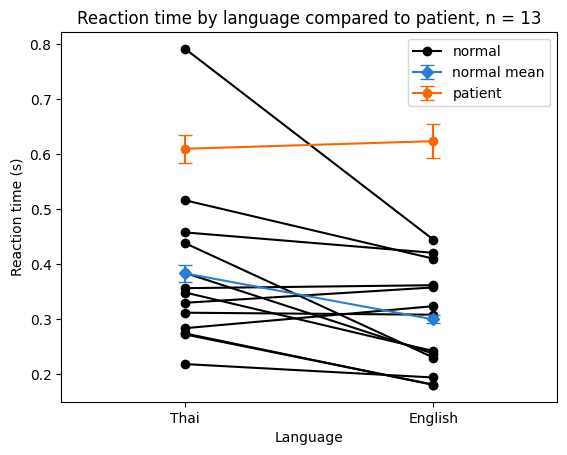

In [22]:
plotdf = megadf_filter.groupby(["lang", "username"])['key_RT'].mean().unstack()
# plotdf = plotdf.drop(index=['PH'])

for i, (user, series) in enumerate(plotdf.items()):

    plt.plot(series.index,series.values, color = 'black', marker = "o", label = 'normal') 
   

#norm overall

sem = megadf_filter.groupby(['lang'])['key_RT'].sem()
mean = megadf_filter.groupby(['lang'])['key_RT'].mean()
plt.errorbar(mean.index, mean.values, yerr = sem.values, fmt = 'D-',color = normcolor, capsize = 5, label = 'normal mean')

# patient
ptthmean = letterordth_filter['key_RT'].mean()
ptenmean = letterorden_filter['key_RT'].mean()
ptthsem = letterordth_filter['key_RT'].sem()
ptensem = letterorden_filter['key_RT'].sem()

plt.errorbar([1,2], [ptthmean, ptenmean],yerr = [ptthsem, ptensem], fmt = 'o-',color = patient,   zorder=10, capsize = 5,label = 'patient')

plt.title(f"Reaction time by language compared to patient, n = {n_subj}")
plt.ylabel("Reaction time (s)")
plt.xlabel("Language")
plt.xticks([1,2], ['Thai', 'English'])
plt.margins(x=0.5)

handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))  # Removes duplicates
plt.legend(unique_labels.values(), unique_labels.keys())
plt.savefig("./figure/norm/I RT by lang order.png")

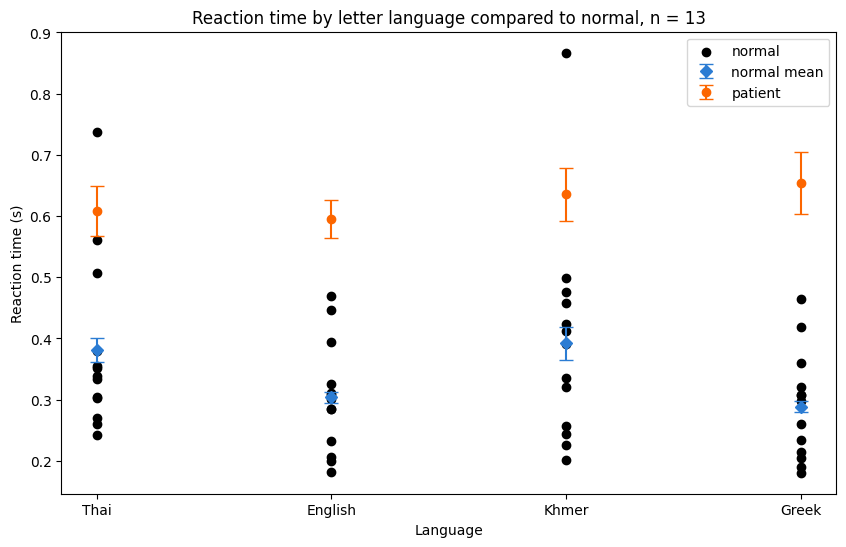

In [23]:
# normal
custom_ord = ['Thai', 'English', 'Khmer','Greek']

normmean = megadf_filter.groupby(['langshow', 'username'])['key_RT'].mean().unstack()
normmean = normmean.reindex(custom_ord)

# each individual
plt.subplots(figsize=(10, 6)) 
for i, (user, sublist) in enumerate(normmean.items()):

    plt.scatter(sublist.index, sublist.values,  color = 'black', label = 'normal')

# norm mean
rtsem = megadf_filter.groupby(['langshow'])['key_RT'].sem()
rtsem = rtsem.reindex(custom_ord)

rtmean = megadf_filter.groupby(['langshow'])['key_RT'].mean()
rtmean = rtmean.reindex(custom_ord)
plt.errorbar(rtmean.index, rtmean.values, yerr = rtsem.values,  fmt = 'D',color = normcolor, capsize = 5, label = 'normal mean' )


#patient
ptmean = letterordall_filter.groupby(['langshow'])['key_RT'].mean()
ptmean =ptmean.reindex(custom_ord)

ptsem = letterordall_filter.groupby(['langshow'])['key_RT'].sem()
ptsem =ptsem.reindex(custom_ord)

plt.errorbar(ptmean.index, ptmean.values,yerr = ptsem.values, fmt = 'o',color = patient,   zorder=10, capsize = 5,label = 'patient')


plt.title(f"Reaction time by letter language compared to normal, n = {n_subj}")
plt.xlabel("Language")
plt.ylabel("Reaction time (s)")

# remove dupe
handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = dict(zip(labels, handles)) 
plt.legend(unique_labels.values(), unique_labels.keys())
plt.savefig('./figure/norm/I RT by langshow.png')

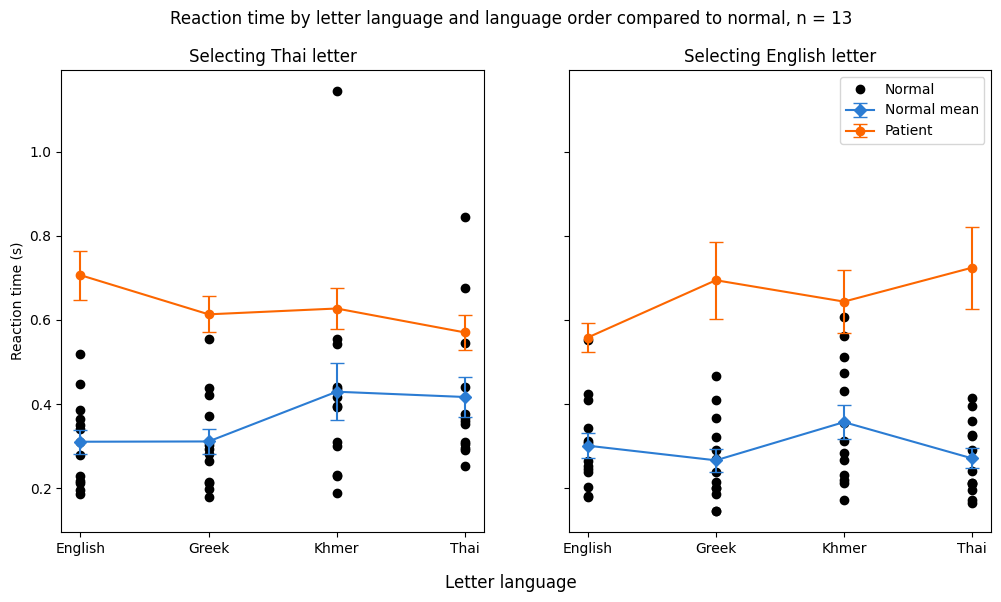

In [24]:
fig, axs = plt.subplots(1, 2, figsize = (12,6), sharey=True)
lister = [[megathdf_filter, letterordth_filter] , [megaendf_filter, letterorden_filter]]
for i in [0,1]:

    d = lister[i][0].groupby(['langshow', 'username'])['key_RT'].mean().unstack()
    for s, v in d.items():
        axs[i].plot(v.index, v.values, color = 'black', marker = 'o', linestyle = '', label = 'Normal')

    mean, sem = d.T.mean(), d.T.sem()
    axs[i].errorbar(mean.index, mean.values, yerr = sem.values, marker = 'D', color = normcolor, capsize = 5, label = 'Normal mean')
    p = lister[i][1].groupby(['langshow'])['key_RT'].mean()
    s = lister[i][1].groupby(['langshow'])['key_RT'].sem()
    axs[i].errorbar(p.index, p.values, yerr = s.values, capsize = 5, color = patient, label = "Patient", marker = 'o')

fig.suptitle(f"Reaction time by letter language and language order compared to normal, n = {n_subj}")
fig.supxlabel("Letter language")
axs[0].set_ylabel("Reaction time (s)")
axs[0].set_title("Selecting Thai letter")
axs[1].set_title("Selecting English letter")

legend_unique()
plt.savefig("./figure/norm/I norm RT by letterlang and language order.png")

